<a href="https://www.kaggle.com/code/vikarna/un-votes-pca?scriptVersionId=94688644" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Business Problem

The United Nations is an intergovernmental organization whose purpose is to maintain international peace and security, develop friendly relations among nations, achieve international cooperation, and be a centre for harmonizing the actions of nations.

The UN was established after World War II with the aim of preventing future wars, succeeding the rather ineffective League of Nations. On 25 April 1945, 50 governments met in San Francisco for a conference and started drafting the UN Charter, which was adopted on 25 June 1945 and took effect on 24 October 1945, when the UN began operations. Pursuant to the Charter, the organization's objectives include maintaining international peace and security, protecting human rights, delivering humanitarian aid, promoting sustainable development, and upholding international law. At its founding, the UN had 51 member states; with the addition of South Sudan in 2011, membership is now 193, representing almost all of the world's sovereign states.

**Data set consits voting records for all resolutions adopted by the General Assembly and the Security Council from 1946 onwards.**

**We will try to analyze the votes and issues for which they were voted on and provide conclusions**

In [3]:
library(tidyverse)
library(recipes)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step




In [7]:
unvotes <- read.csv('../input/unvotes/unvotes.csv')
issues <- read.csv('../input/issues/issues.csv')
head(unvotes)
head(issues)

,rcid,country,country_code,vote
,<int>,<fct>,<fct>,<fct>
1,3,United States,US,yes
2,3,Canada,CA,no
3,3,Cuba,CU,yes
4,3,Haiti,HT,yes
5,3,Dominican Republic,DO,yes
6,3,Mexico,MX,yes


,rcid,short_name,issue
,<int>,<fct>,<fct>
1,77,me,Palestinian conflict
2,9001,me,Palestinian conflict
3,9002,me,Palestinian conflict
4,9003,me,Palestinian conflict
5,9004,me,Palestinian conflict
6,9005,me,Palestinian conflict


**One data set contains the votes and another contains the issue on which the vote was based on..**

Let’s create a wide version of this data set via pivot_wider() to use for modeling.

**We will join the two tables so that analysis could be easier **

In [8]:

unvotes_df <- unvotes %>%
  select(country, rcid, vote) %>%
  mutate(
    vote = factor(vote, levels = c("no", "abstain", "yes")),
    vote = as.numeric(vote),
    rcid = paste0("rcid_", rcid)
  ) %>%
  pivot_wider(names_from = "rcid", values_from = "vote", values_fill = 2)

head(unvotes_df)

country,rcid_3,rcid_4,rcid_5,rcid_6,rcid_7,rcid_8,rcid_9,rcid_10,rcid_11,⋯,rcid_9090,rcid_9093,rcid_9085,rcid_9086,rcid_9095,rcid_9092,rcid_9097,rcid_9100,rcid_9098,rcid_9101
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
United States,3,1,1,1,1,1,3,3,3,⋯,2,1,1,1,1,1,1,1,1,1
Canada,1,1,1,1,1,3,3,3,3,⋯,3,1,2,2,2,1,3,1,2,1
Cuba,3,1,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
Haiti,3,1,1,2,3,2,3,3,2,⋯,3,2,2,2,2,2,3,3,3,2
Dominican Republic,3,1,1,2,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
Mexico,3,1,3,3,3,3,3,3,2,⋯,3,3,3,3,3,3,3,3,3,2


In [9]:

pca_rec <- recipe(~., data = unvotes_df) %>%
  update_role(country, new_role = "id") %>%
  step_normalize(all_predictors()) %>%
  step_pca(all_predictors(), num_comp = 5)

pca_prep <- prep(pca_rec)

pca_prep

Data Recipe

Inputs:

      role #variables
        id          1
 predictor       6202

Training data contained 200 data points and no missing data.

Operations:

Centering and scaling for rcid_3, rcid_4, rcid_5, rcid_6, rcid_7, ... [trained]
PCA extraction with rcid_3, rcid_4, rcid_5, rcid_6, rcid_7, ... [trained]

We can look at where the countries are in the principal component space by baking the prepped recipe.

In [ ]:
bake(pca_prep, new_data = NULL) %>%
  ggplot(aes(PC1, PC2, label = country)) +
  geom_point(color = "midnightblue", alpha = 0.7, size = 2) +
  geom_text(check_overlap = TRUE, hjust = "inward", family = "IBMPlexSans") +
  labs(color = NULL)


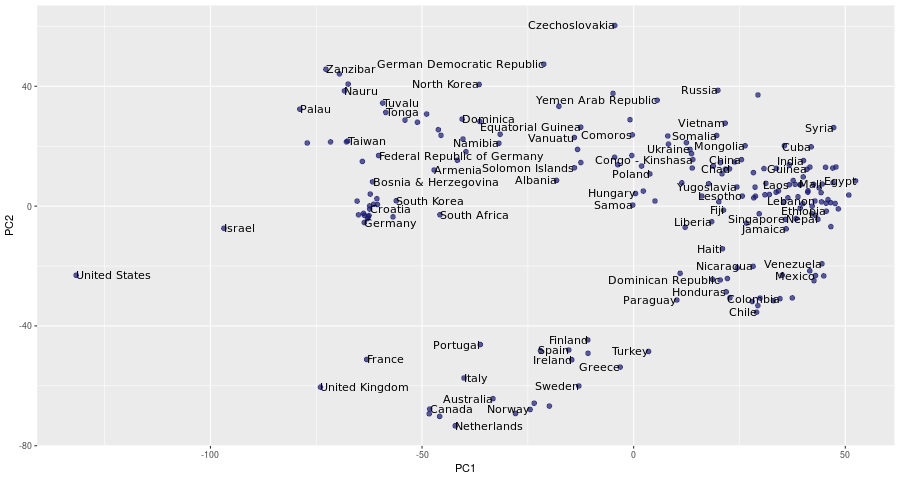

In [1]:
head(issues)

ERROR: Error in head(issues): object 'issues' not found


We can look at which votes contribute to the component by tidying the prepped recipe. Let’s join the roll call votes up with the topics to see which topics contribute to the top principal components.

In [ ]:
pca_comps <- tidy(pca_prep, 2) %>%
  filter(component %in% paste0("PC", 1:4)) %>%
  left_join(issues %>% mutate(terms = paste0("rcid_", rcid))) %>%
  filter(!is.na(issue)) %>%
  group_by(component) %>%
  top_n(8, abs(value)) %>%
  ungroup()

pca_comps %>%
  mutate(value = abs(value)) %>%
  ggplot(aes(value, fct_reorder(terms, value), fill = issue)) +
  geom_col(position = "dodge") +
  facet_wrap(~component, scales = "free_y") +
  labs(
    x = "Absolute value of contribution",
    y = NULL, fill = NULL,
    title = "What issues are most important in UN voting country differences?",
    subtitle = "Human rights and economic development votes account for the most variation"
  )



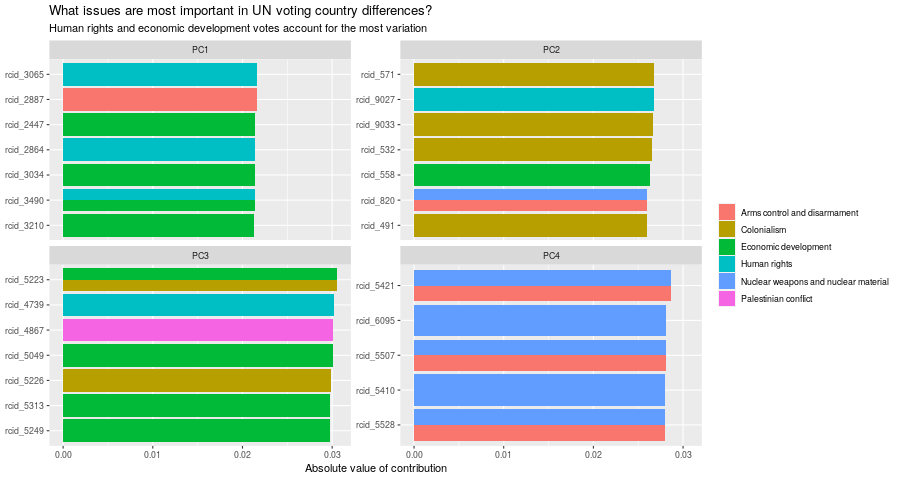

The PCA implementation did not know about the topics of the votes, but notice how the first principal component is mostly about human rights and economic development, the second principal component is mostly about colonialsim, and so on.

UMAP
To switch out for a different dimensionality reduction approach, we just need to change to a different recipe step_(). Let’s try out UMAP, a different algorithm for dimensionality reduction based on ideas from topological data analysis, which is available in the embed package.

In [12]:
library(embed)

umap_rec <- recipe(~., data = unvotes_df) %>%
  update_role(country, new_role = "id") %>%
  step_normalize(all_predictors()) %>%
  step_umap(all_predictors())

umap_prep <- prep(umap_rec)

umap_prep

Data Recipe

Inputs:

      role #variables
        id          1
 predictor       6202

Training data contained 200 data points and no missing data.

Operations:

Centering and scaling for rcid_3, rcid_4, rcid_5, rcid_6, rcid_7, ... [trained]
UMAP embedding for rcid_3, rcid_4, rcid_5, rcid_6, rcid_7, ... [trained]

In [ ]:
bake(umap_prep, new_data = NULL) %>%
  ggplot(aes(umap_1, umap_2, label = country)) +
  geom_point(color = "midnightblue", alpha = 0.7, size = 2) +
  geom_text(check_overlap = TRUE, hjust = "inward", family = "IBMPlexSans") +
  labs(color = NULL)

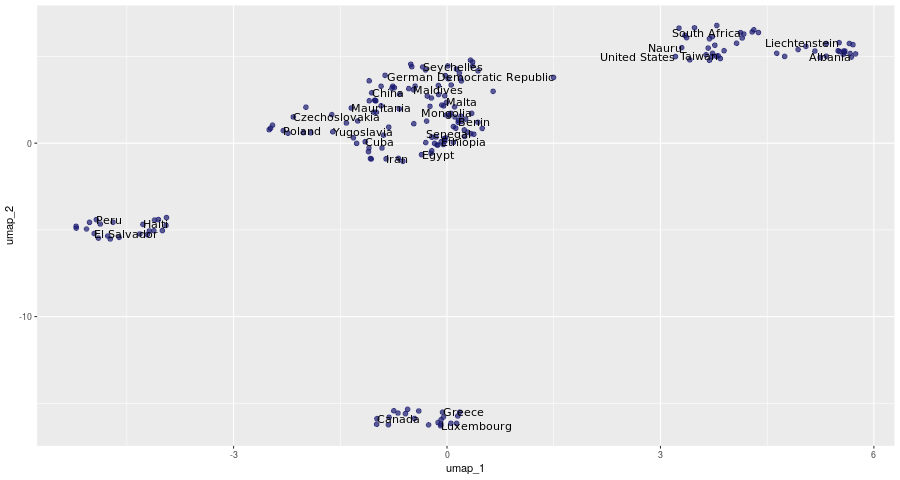

**Above viz shows nature of clustering of countries who voted in similar way and on similar issues concerning their interests and moral compass**